In [1]:
import os
from os.path import exists, join

import matplotlib.animation as animation
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tifffile import imread, imwrite
import ffmpeg
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

pd.options.mode.chained_assignment = None  # default='warn'

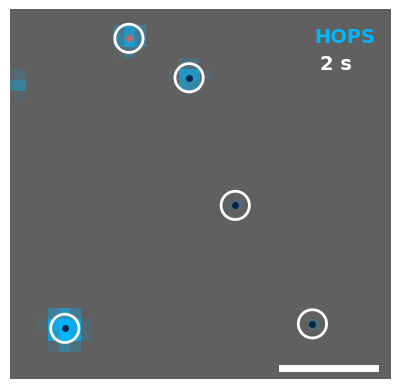

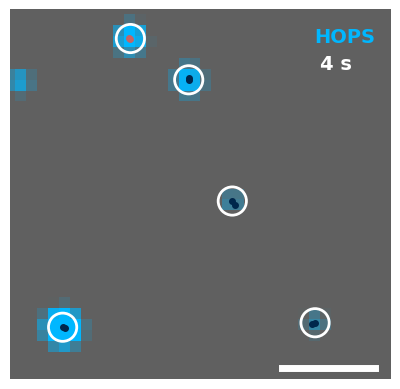

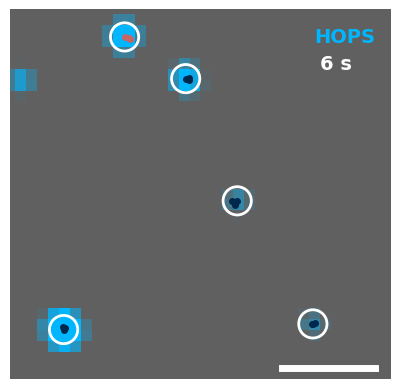

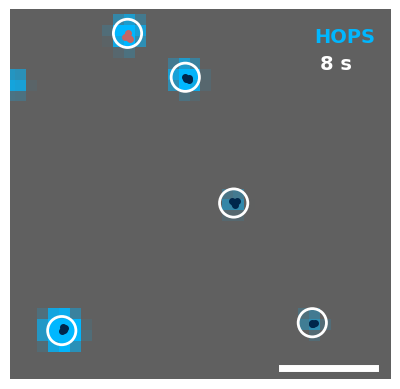

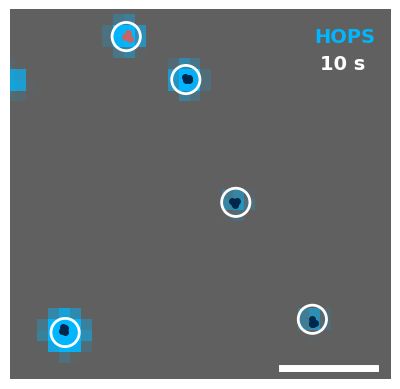

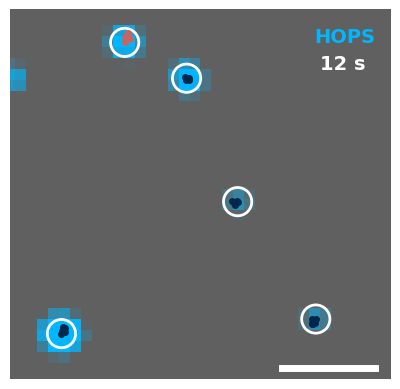

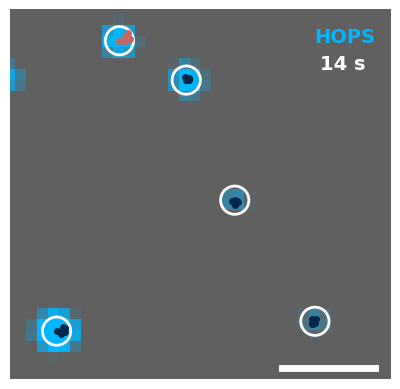

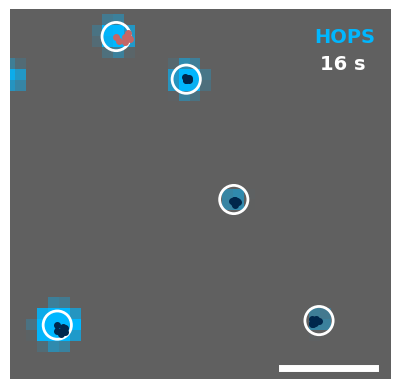

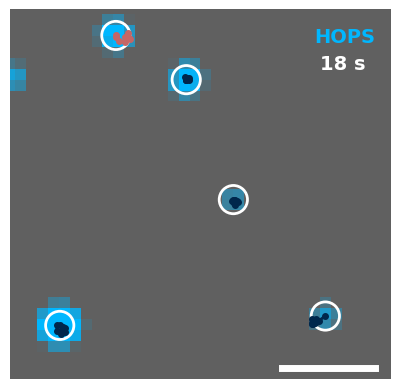

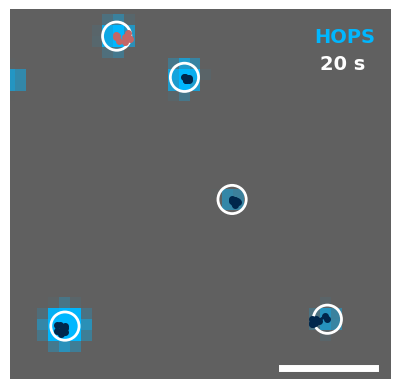

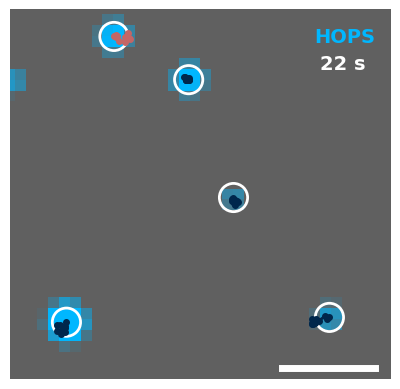

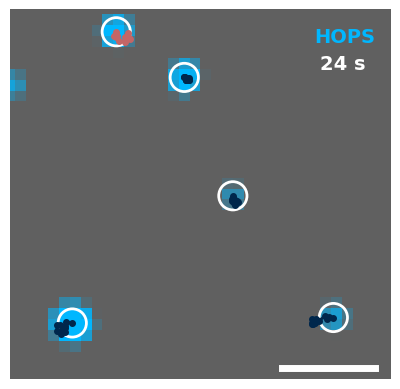

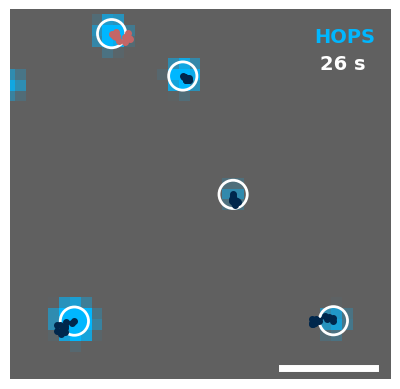

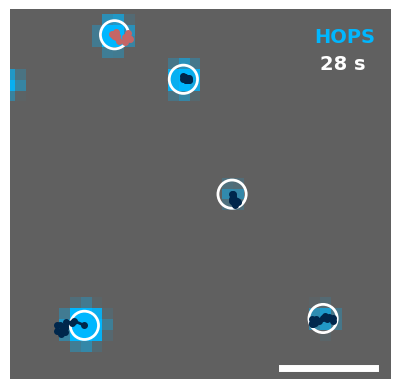

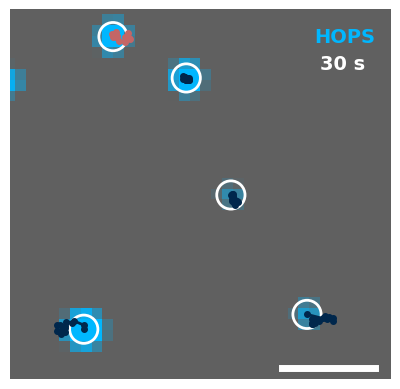

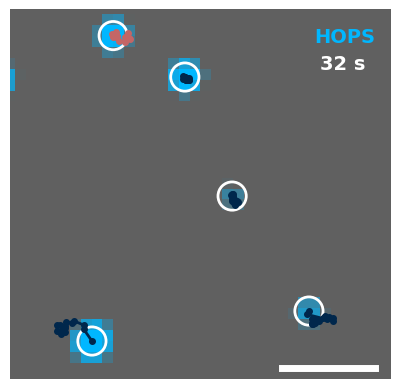

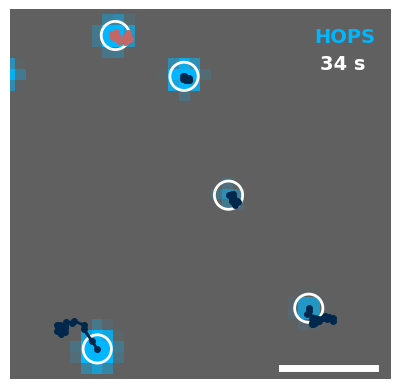

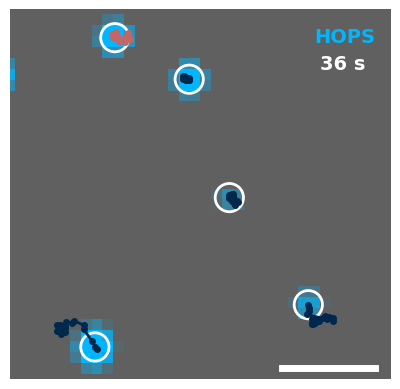

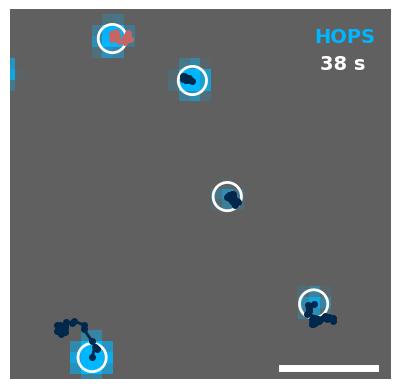

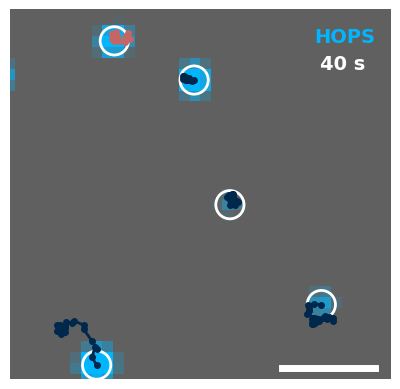

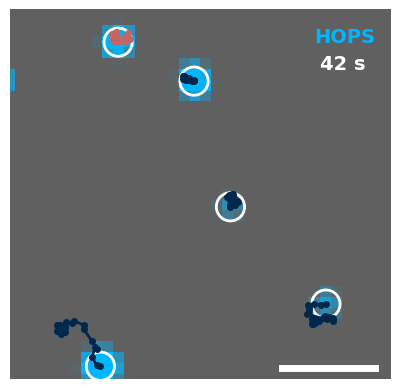

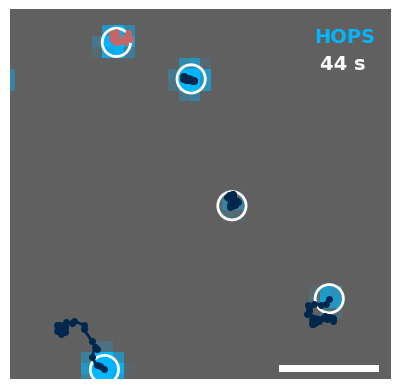

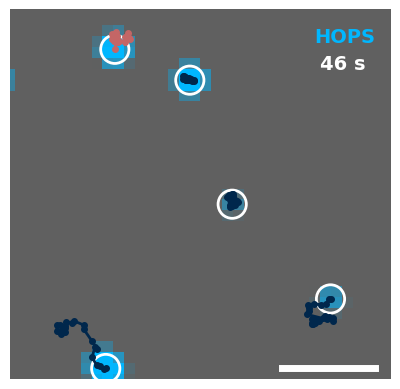

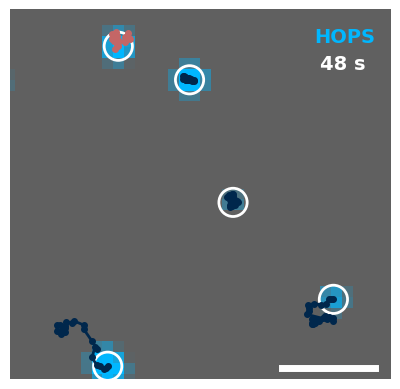

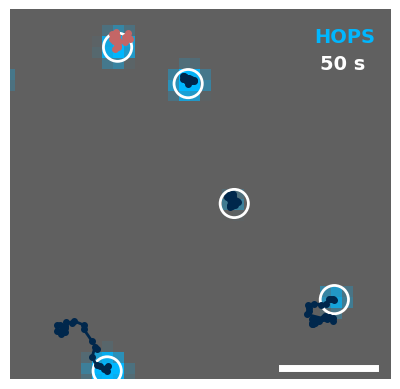

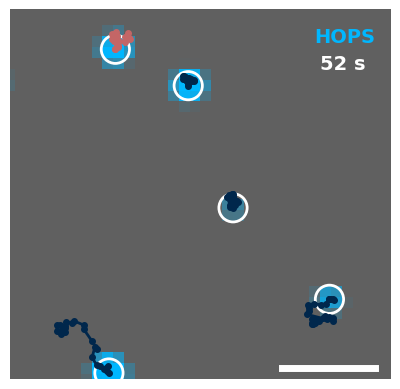

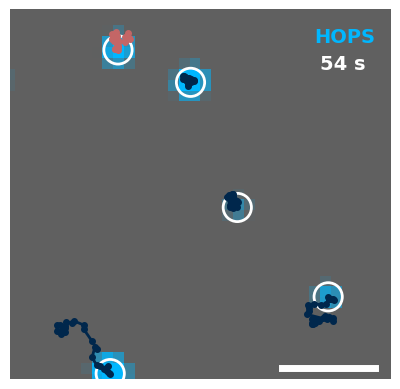

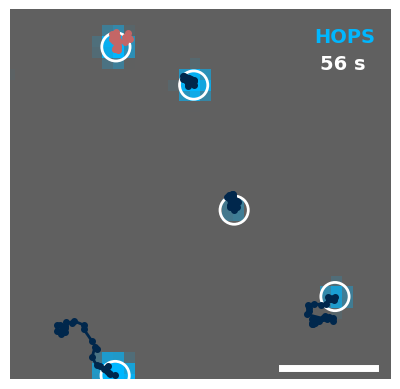

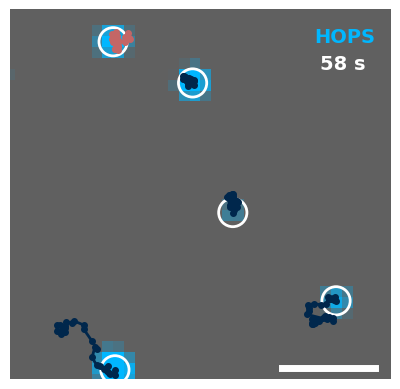

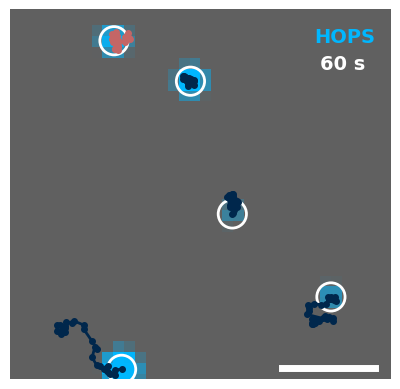

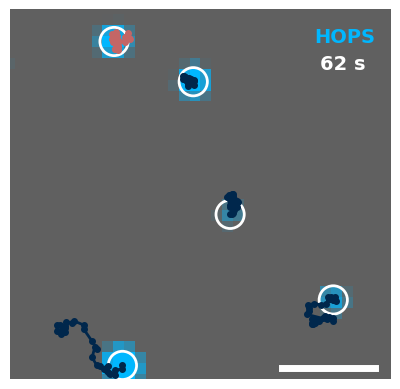

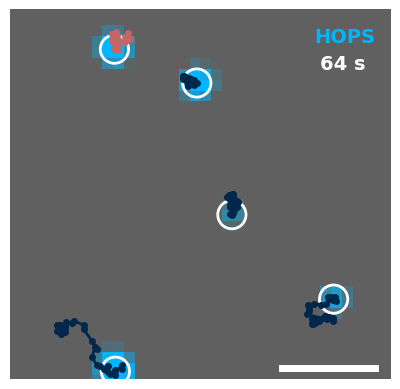

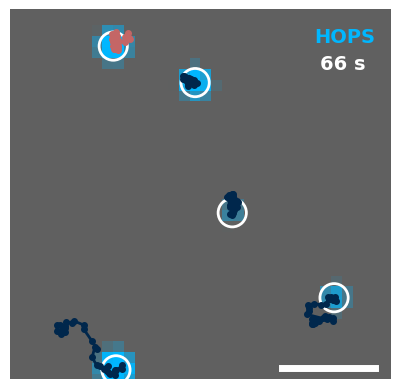

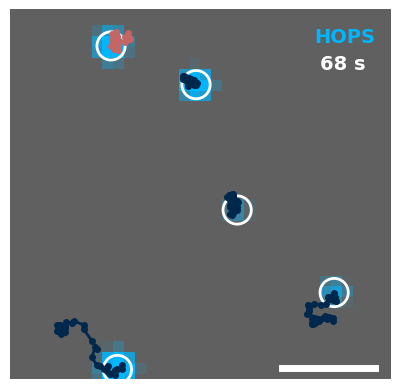

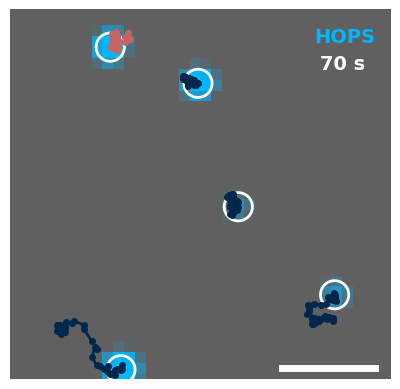

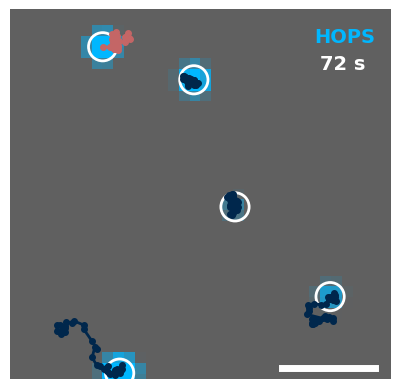

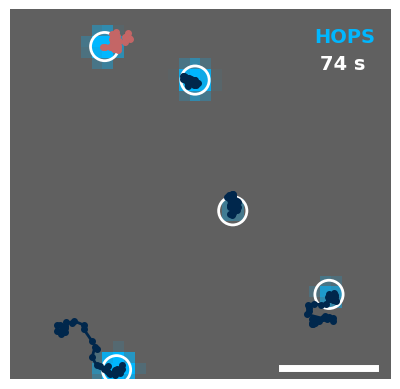

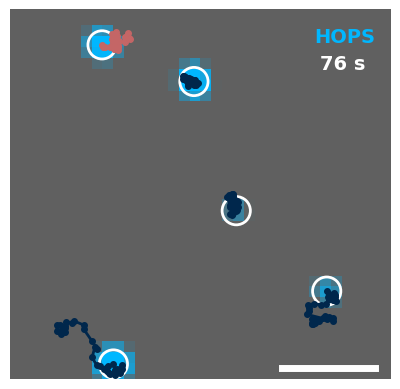

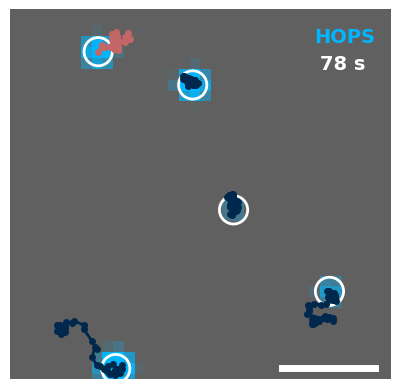

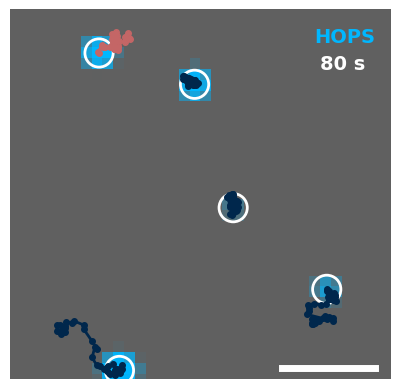

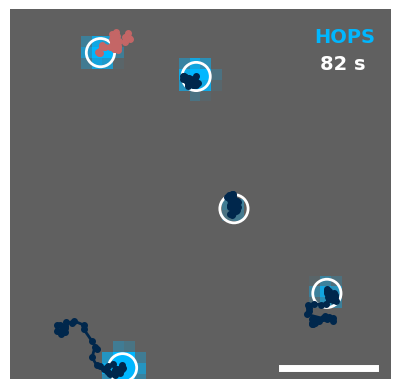

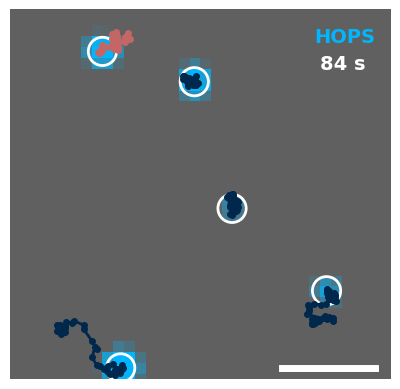

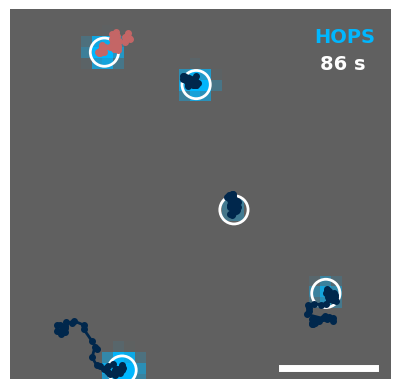

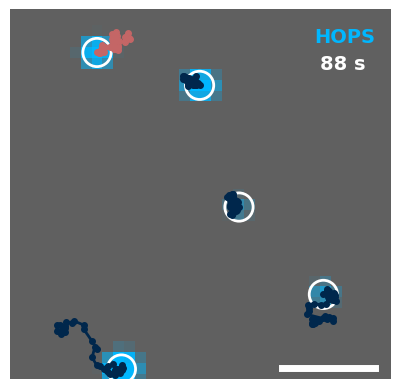

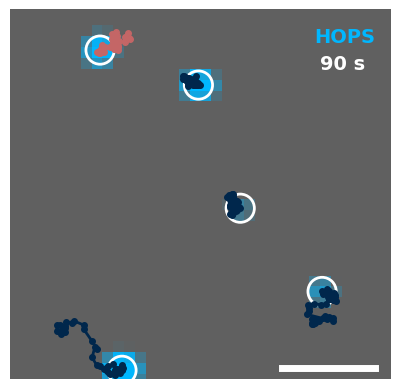

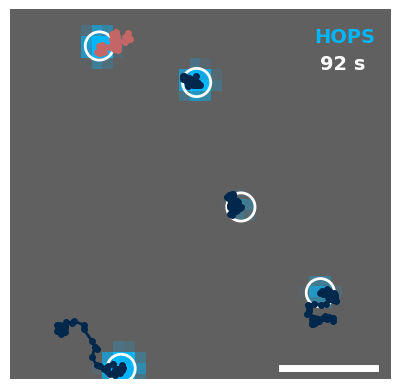

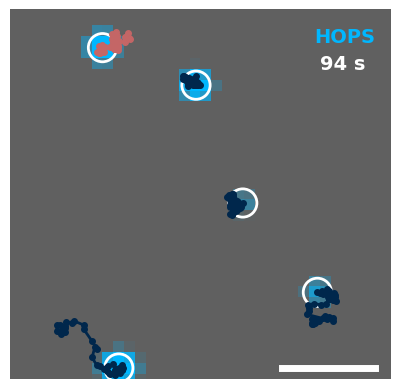

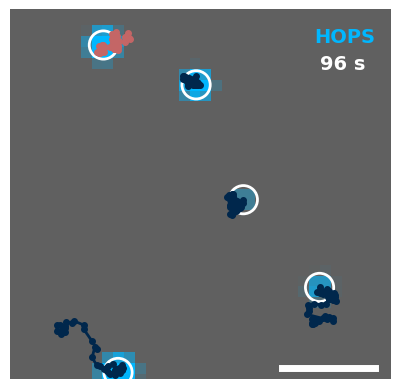

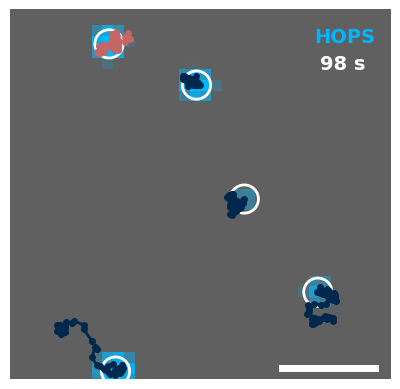

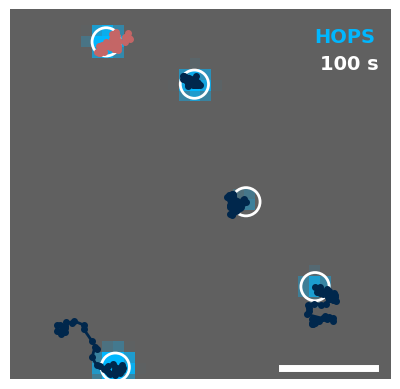

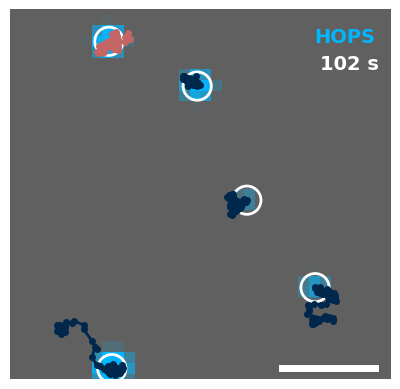

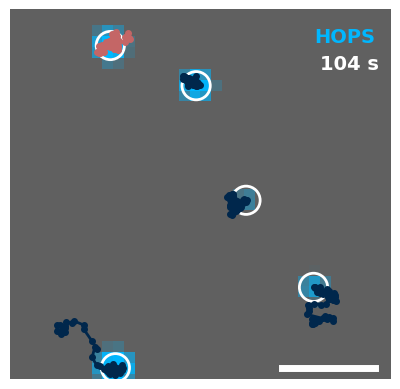

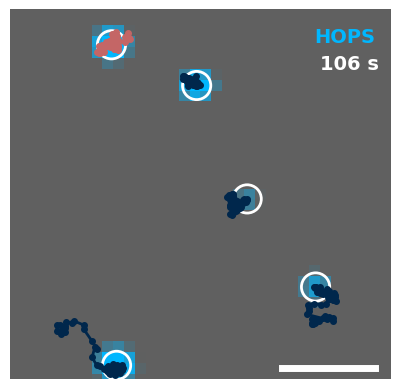

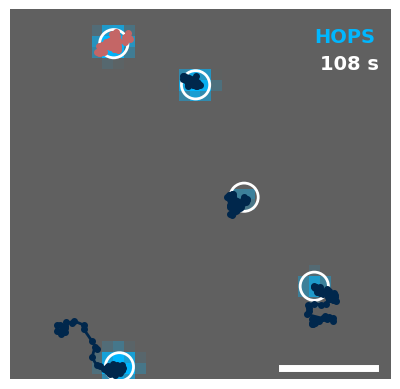

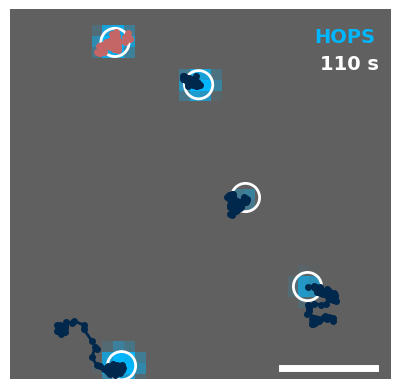

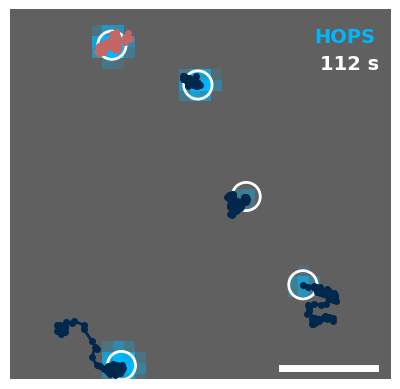

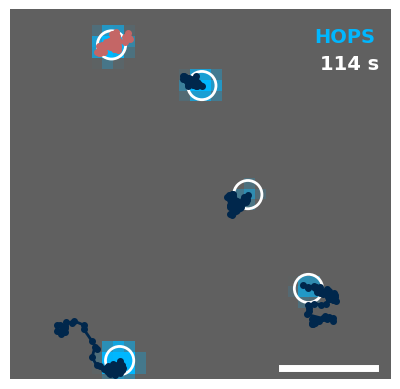

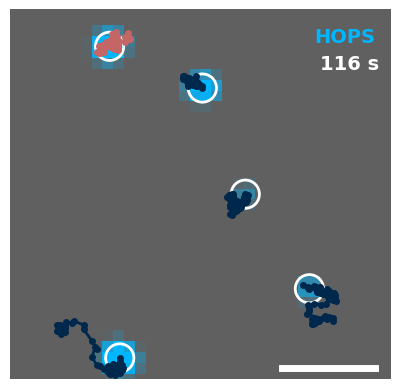

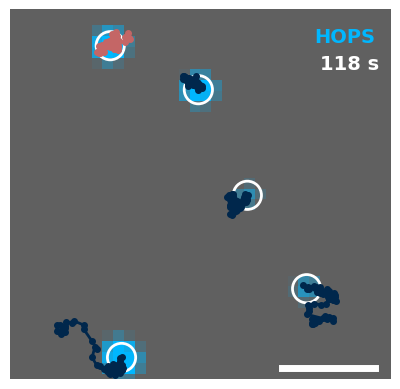

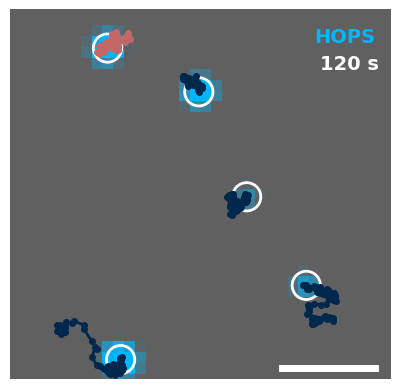

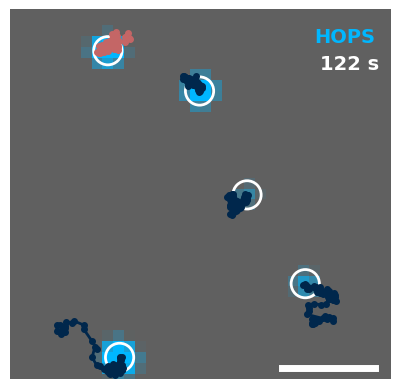

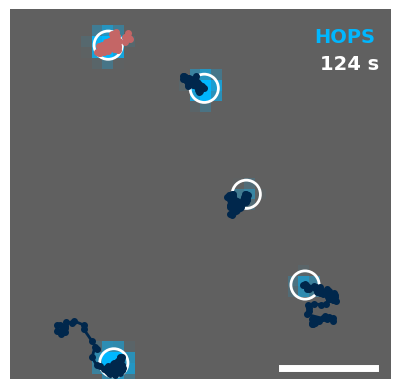

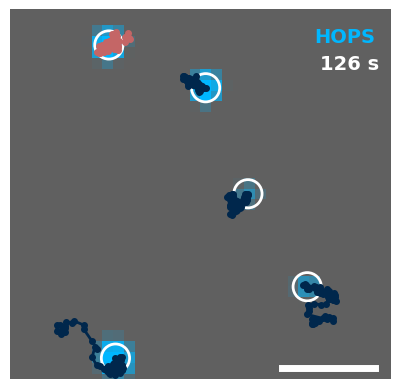

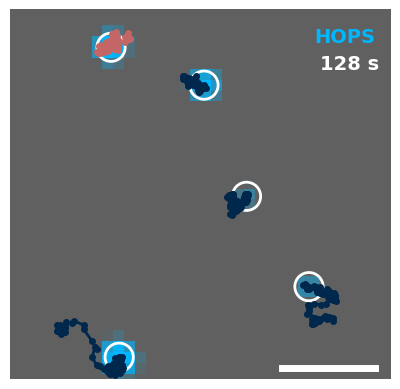

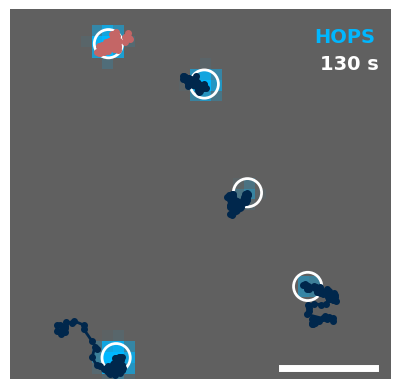

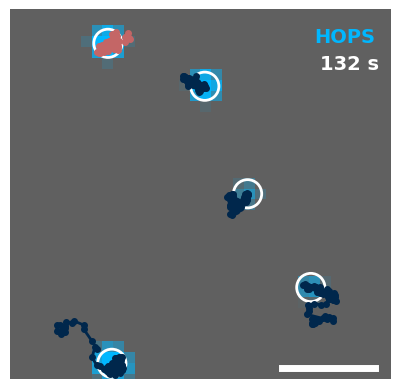

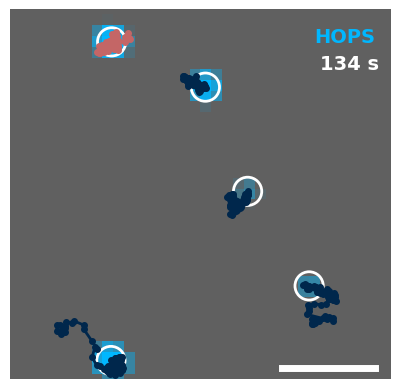

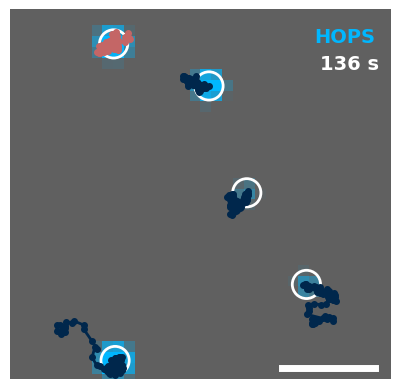

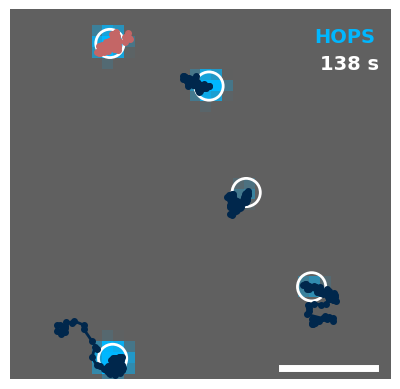

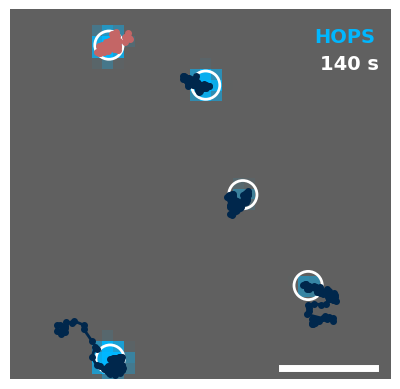

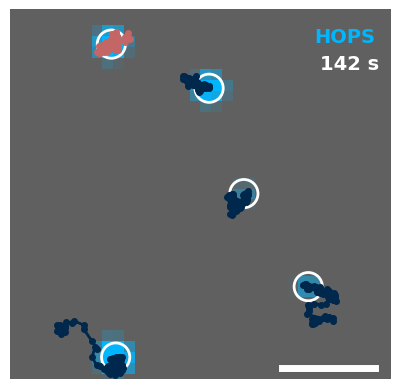

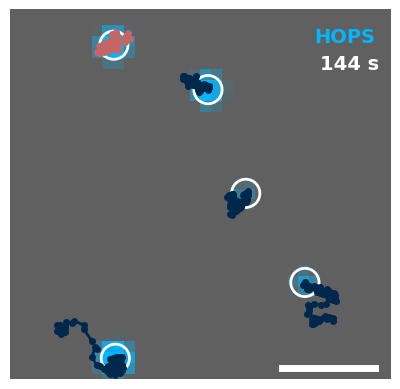

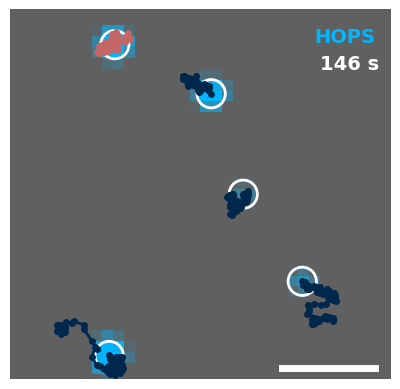

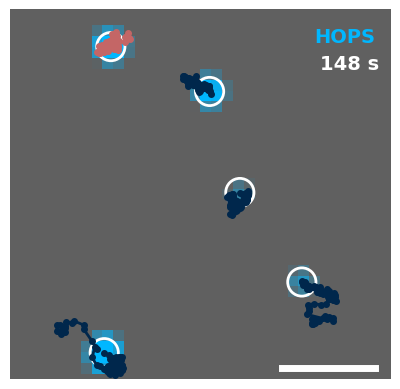

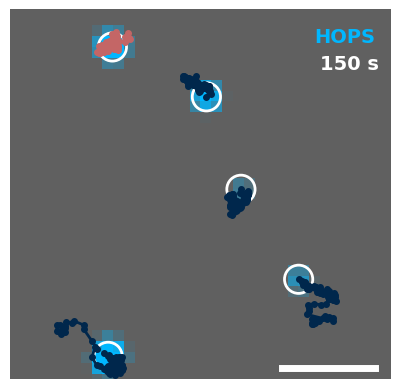

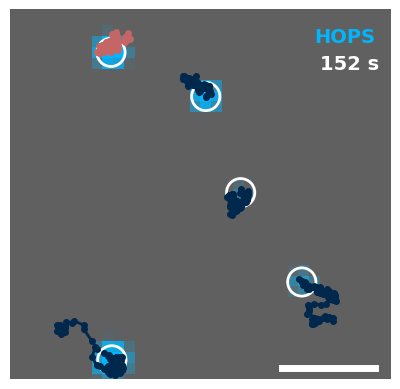

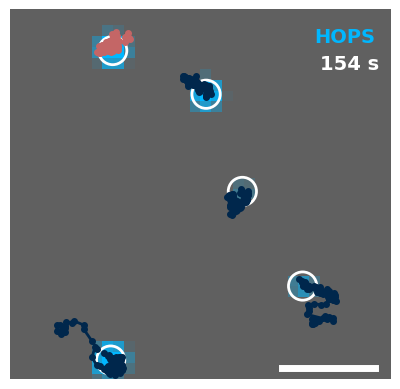

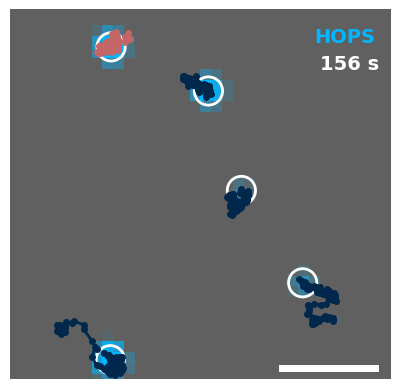

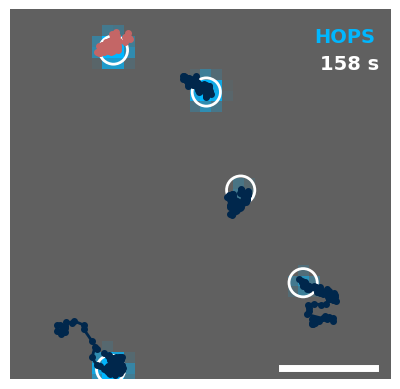

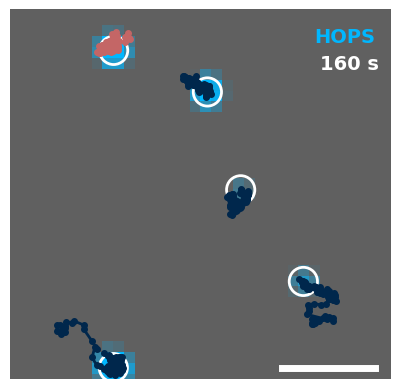

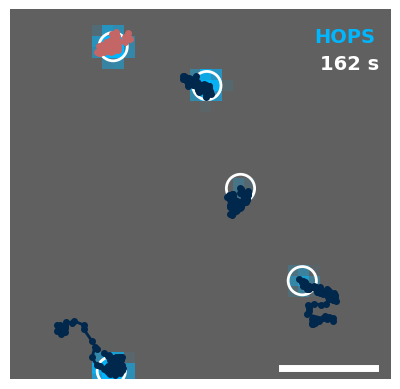

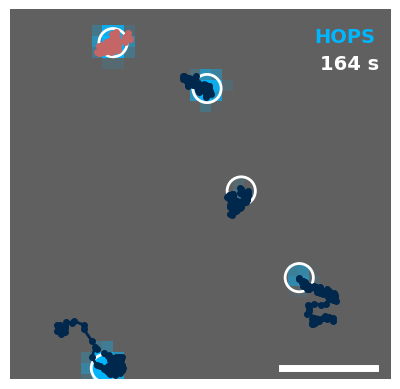

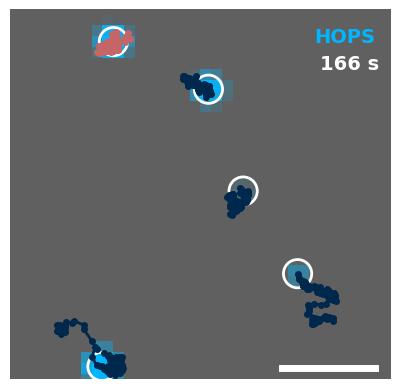

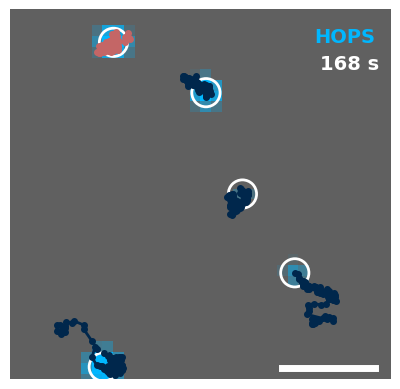

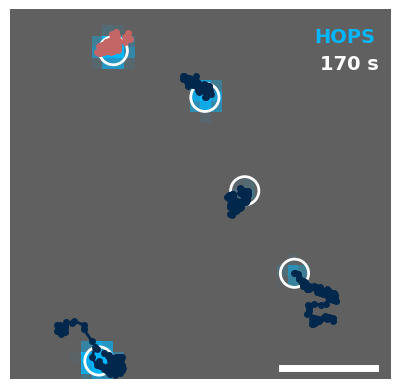

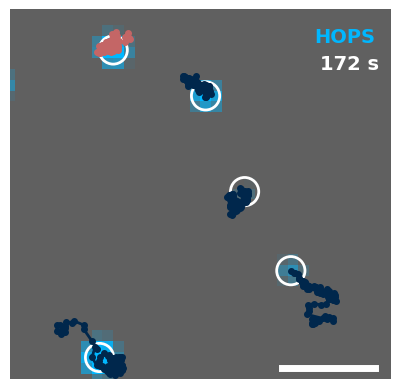

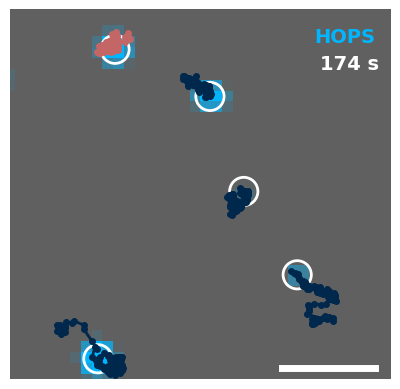

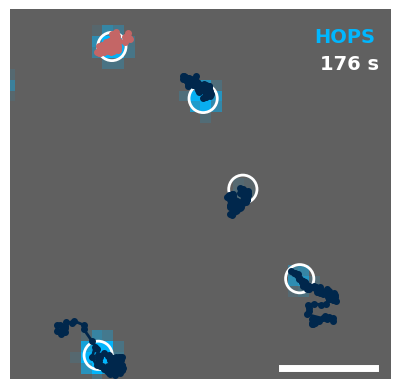

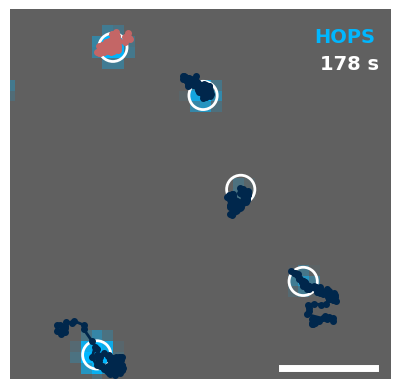

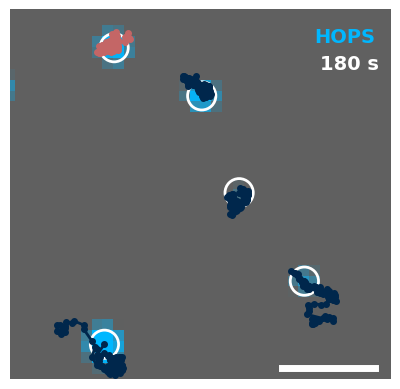

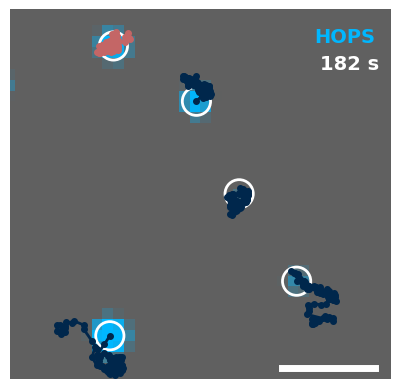

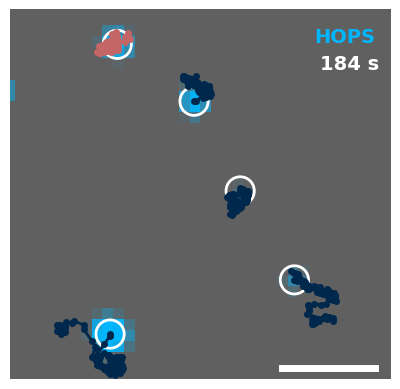

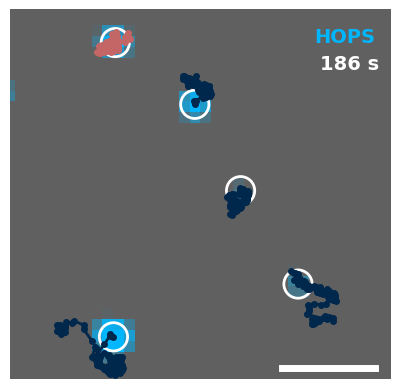

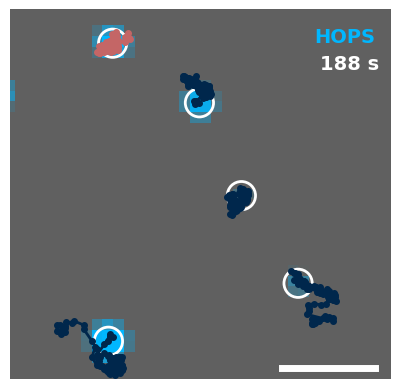

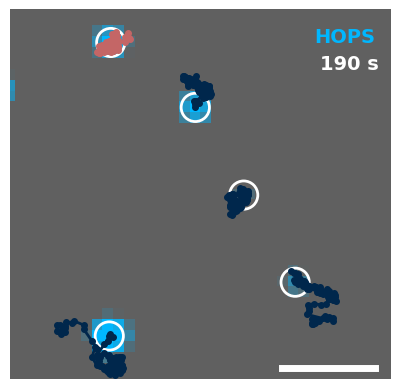

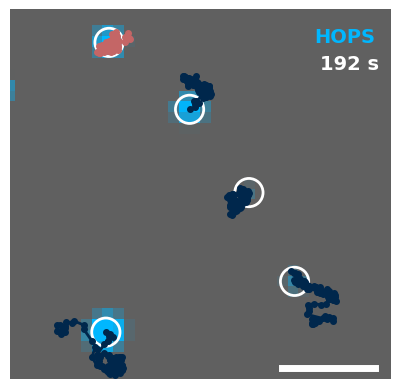

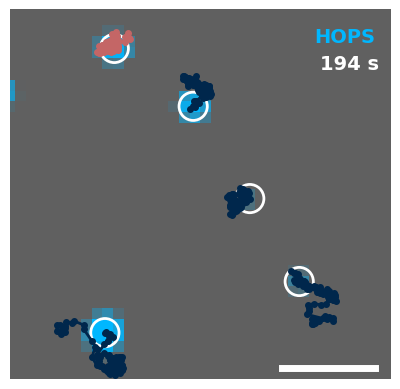

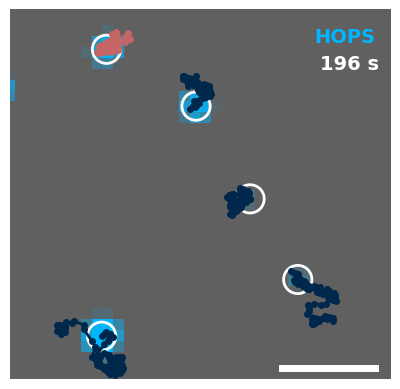

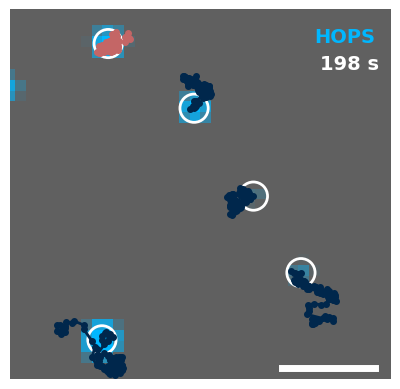

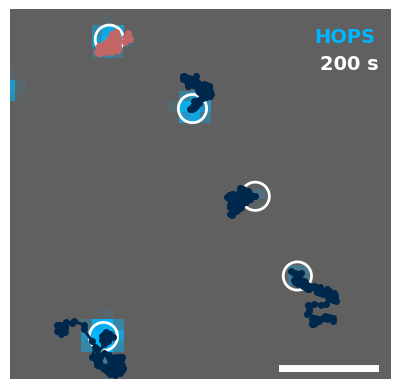

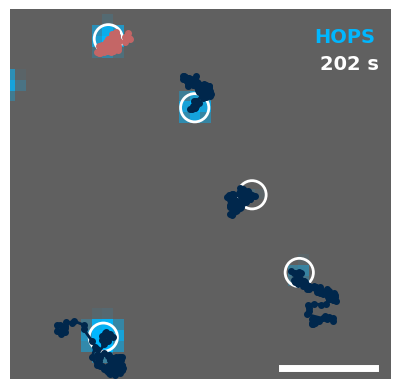

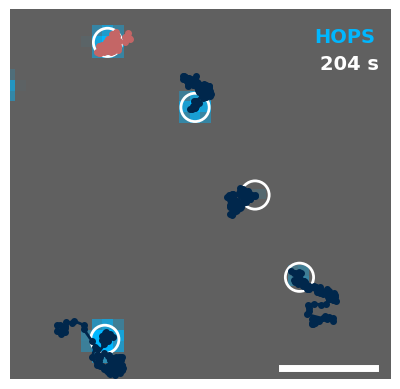

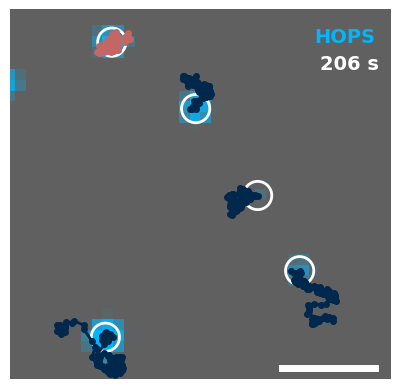

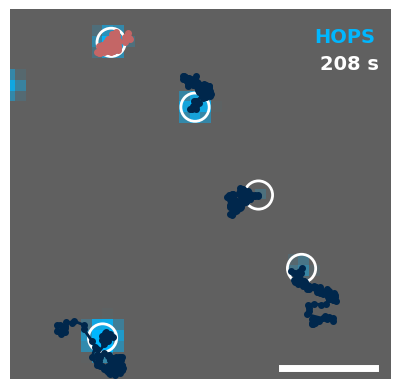

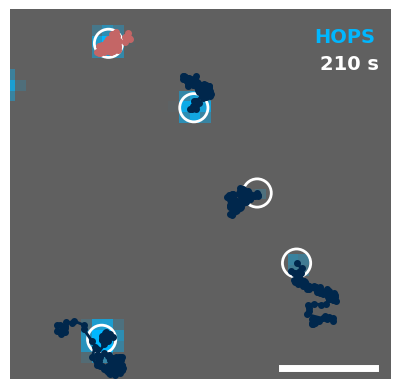

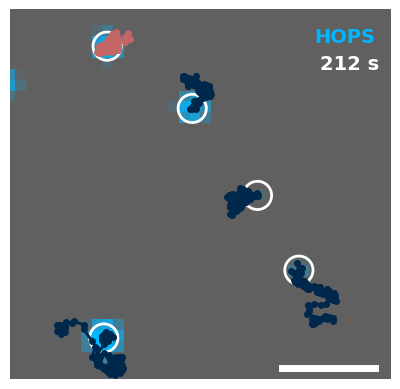

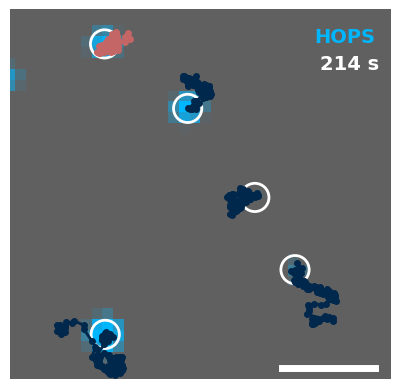

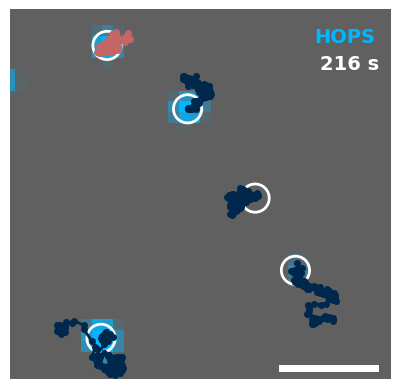

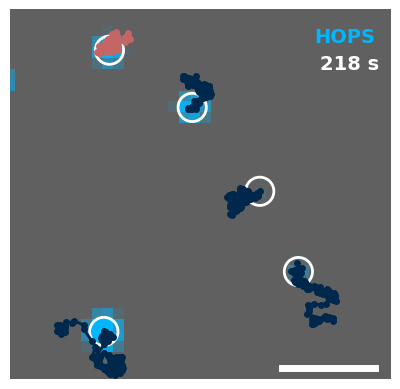

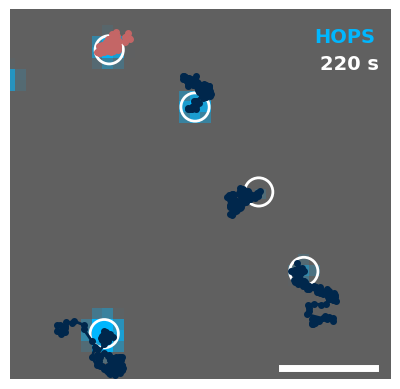

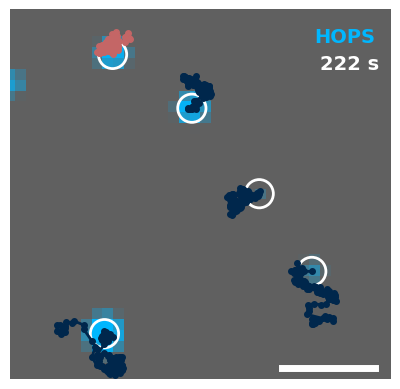

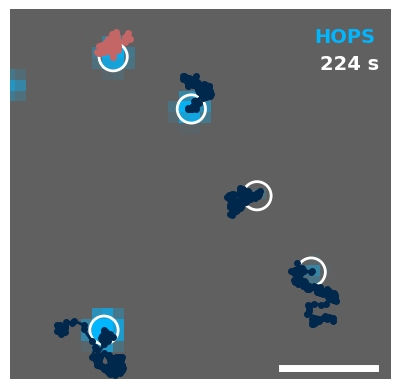

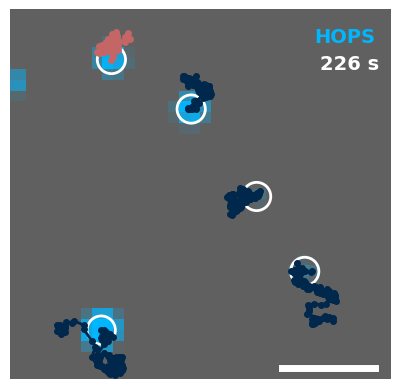

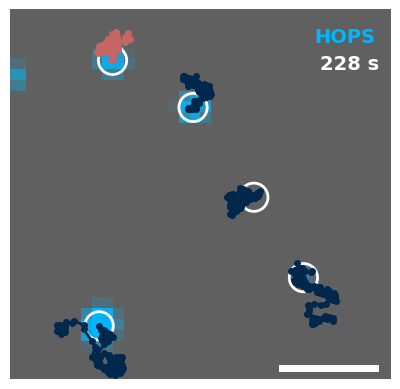

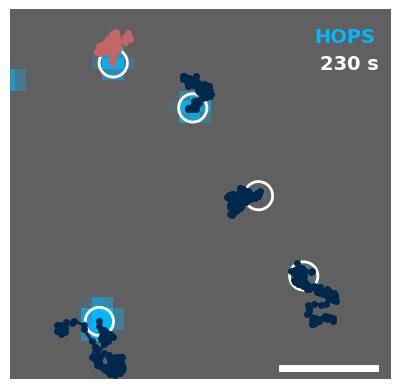

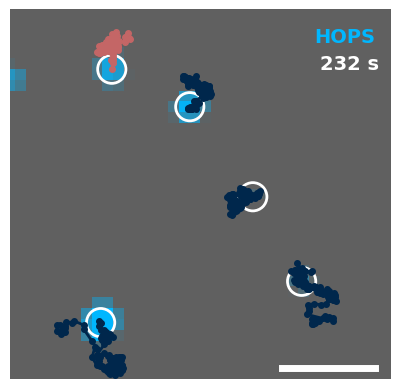

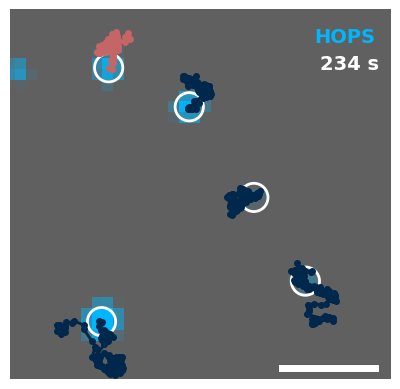

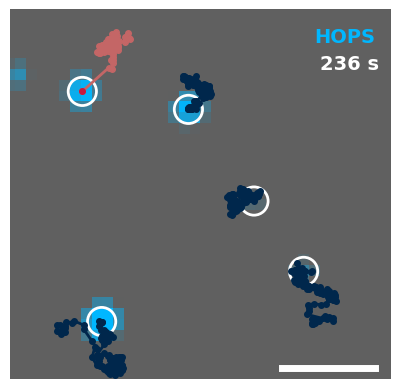

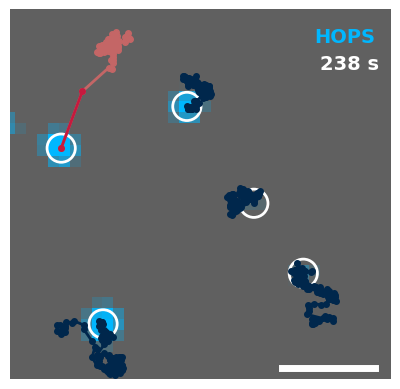

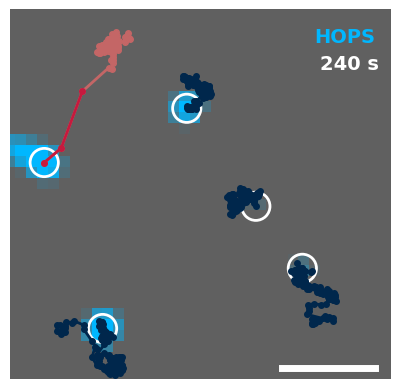

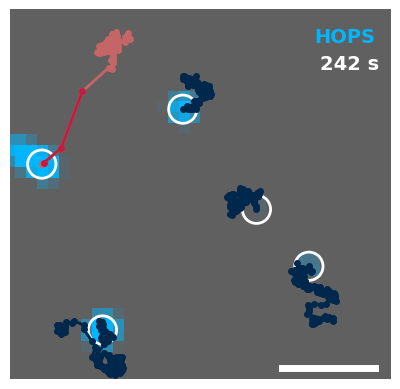

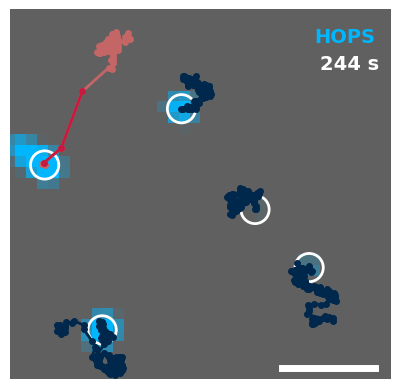

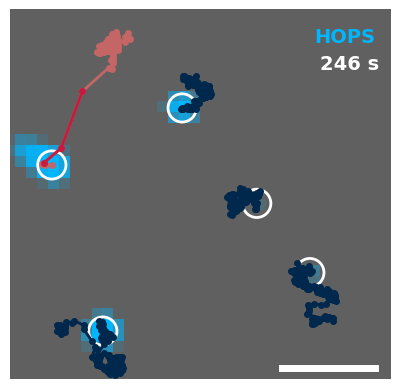

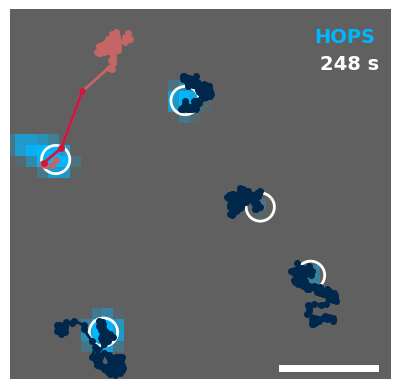

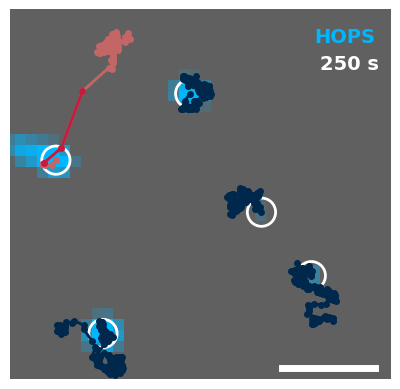

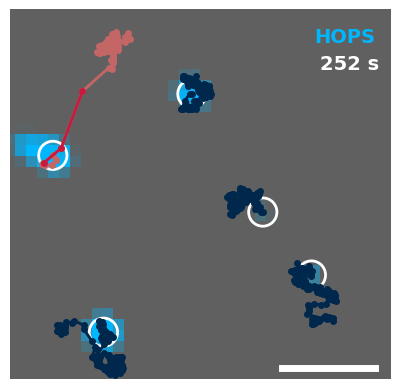

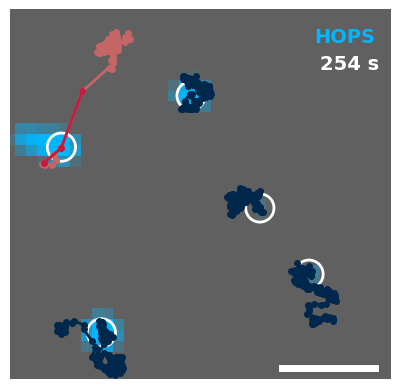

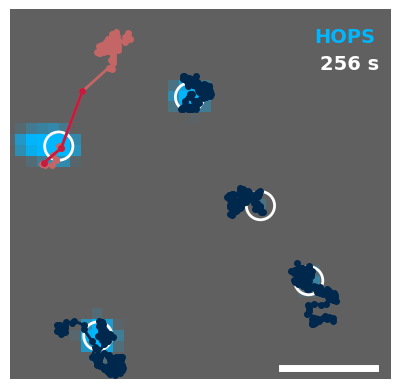

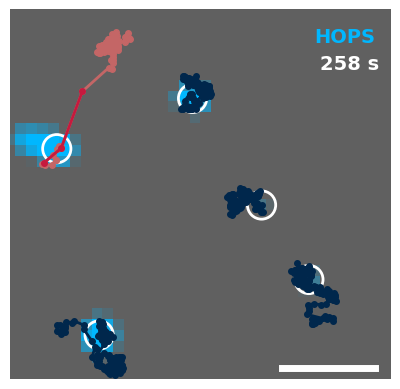

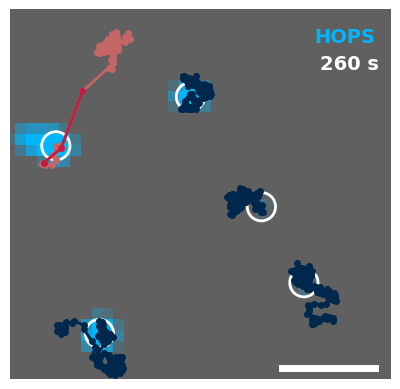

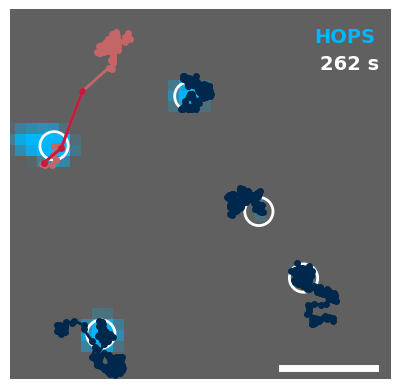

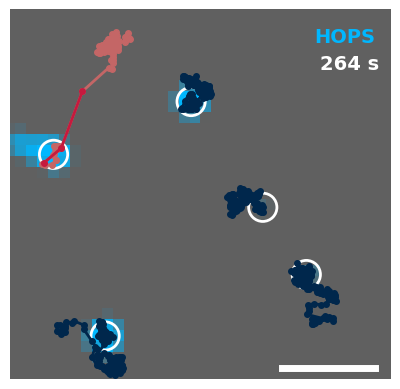

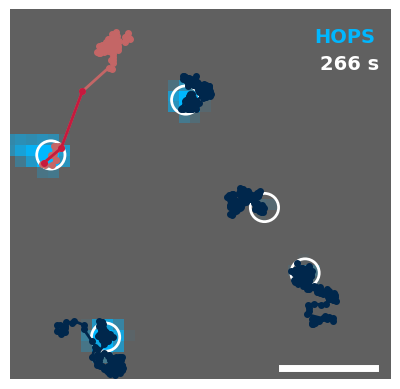

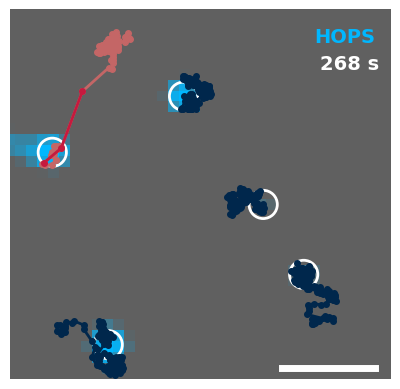

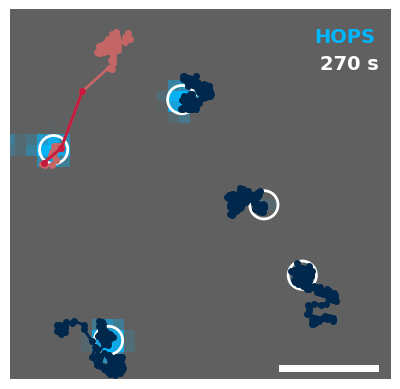

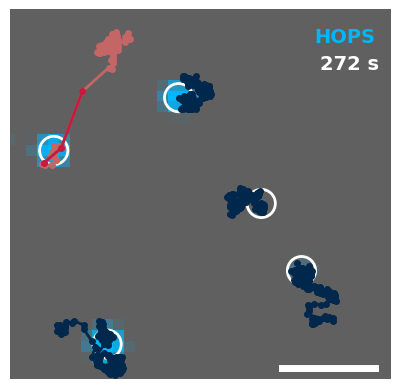

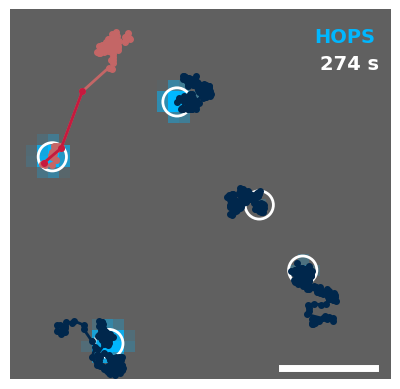

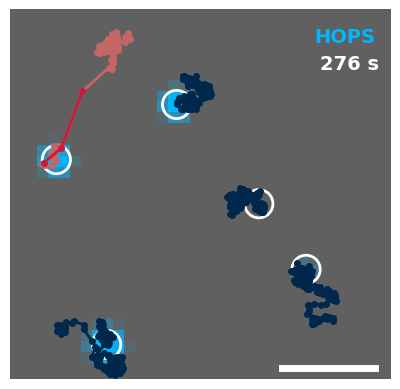

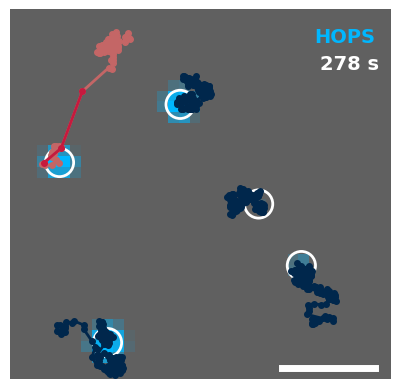

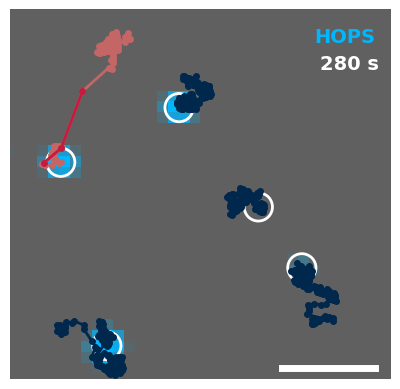

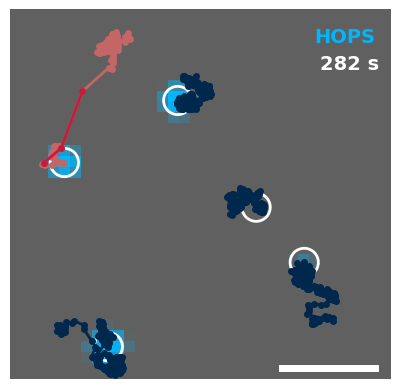

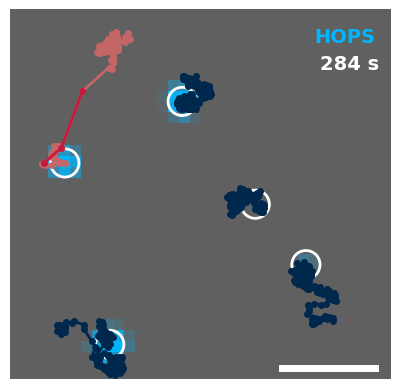

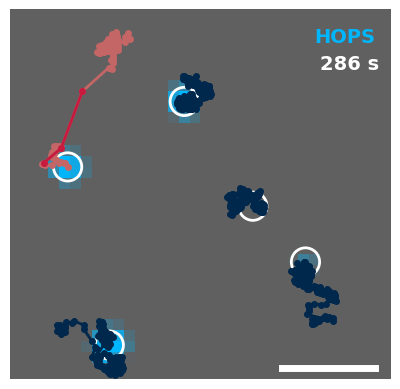

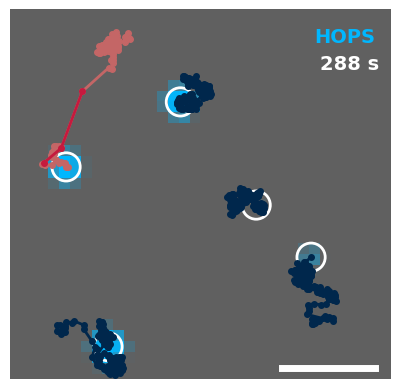

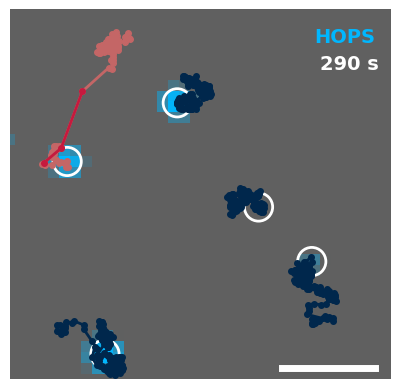

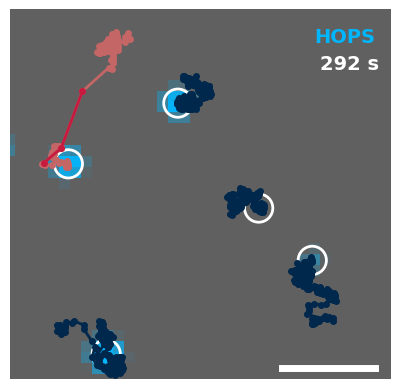

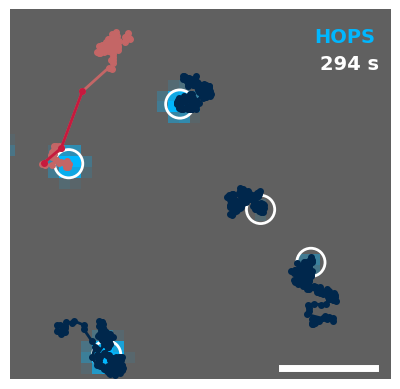

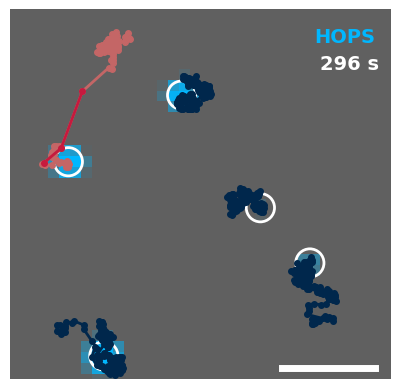

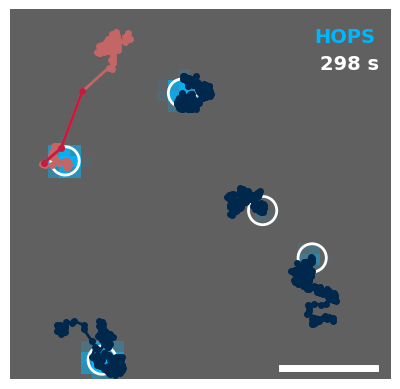

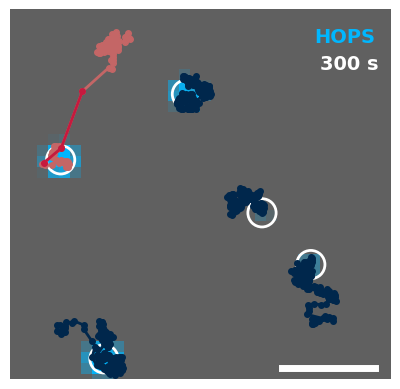

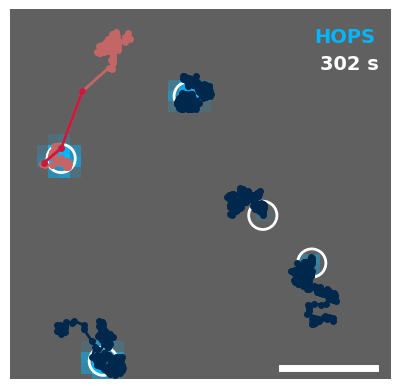

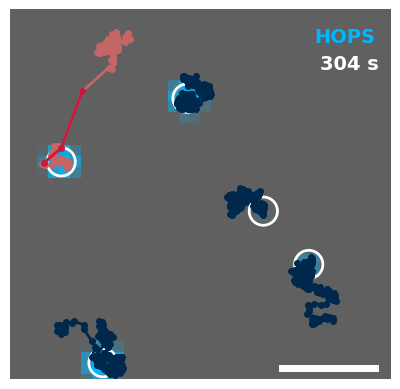

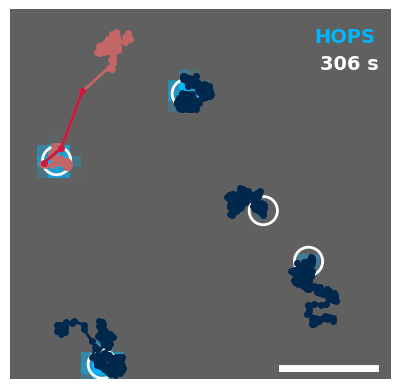

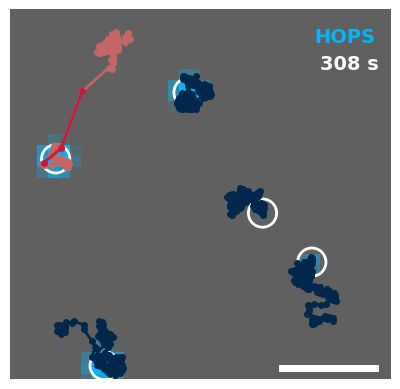

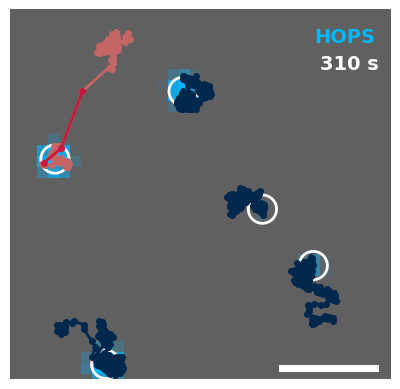

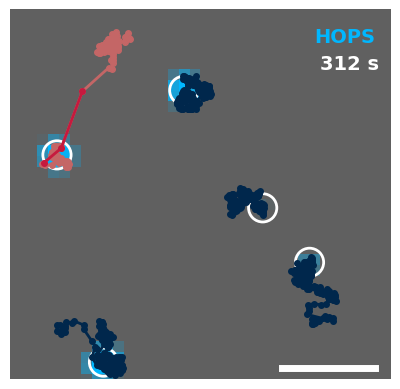

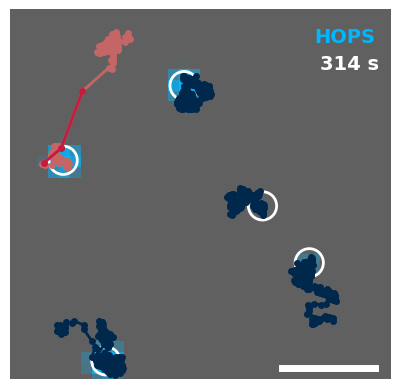

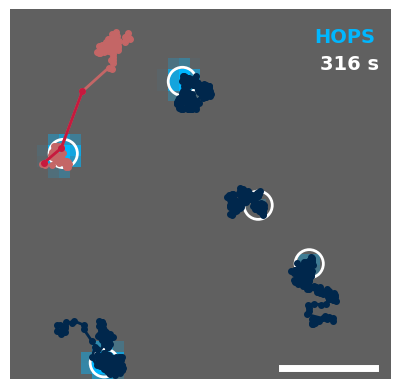

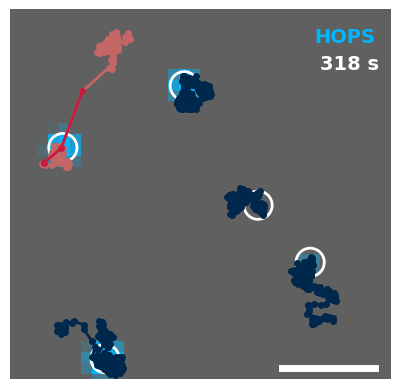

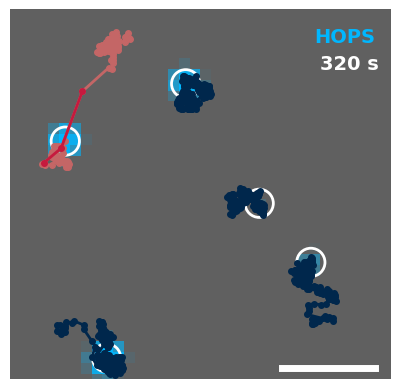

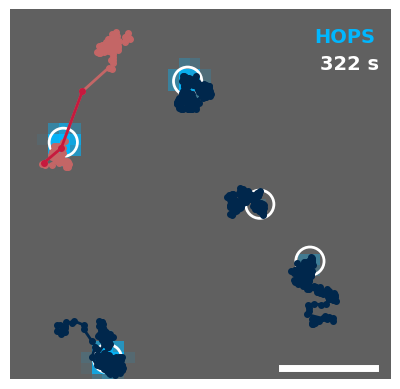

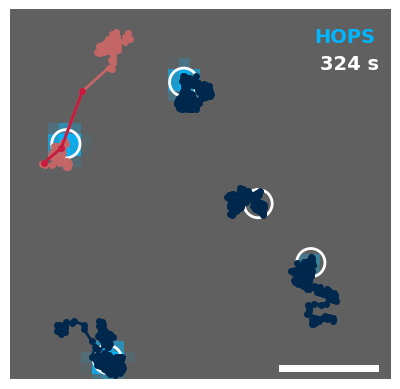

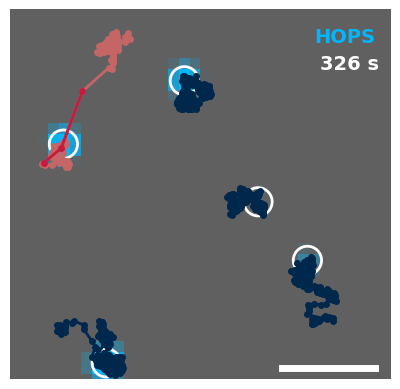

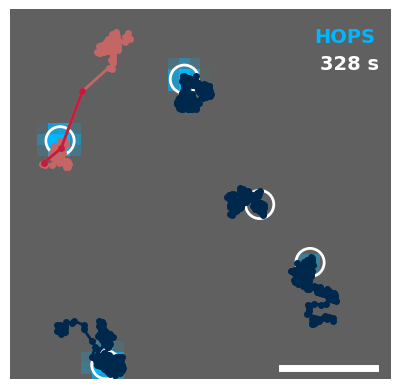

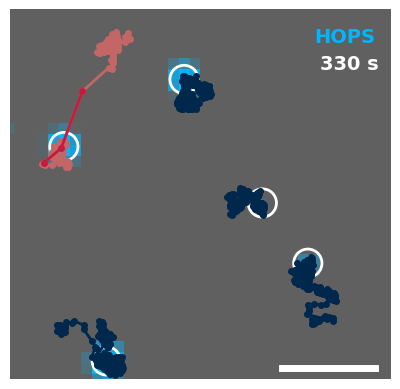

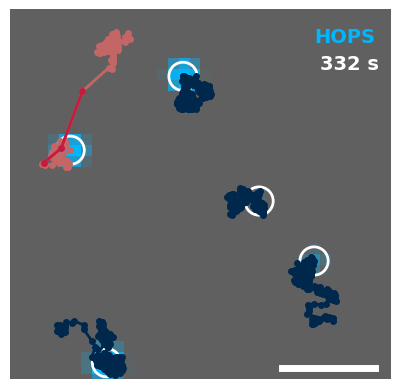

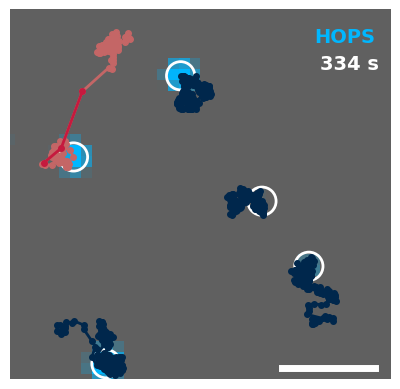

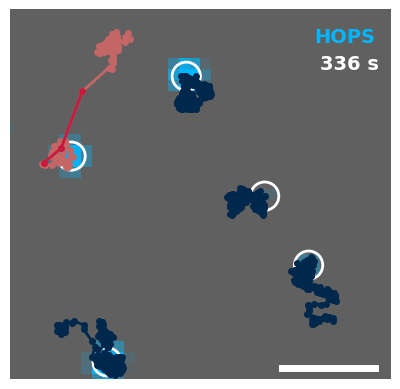

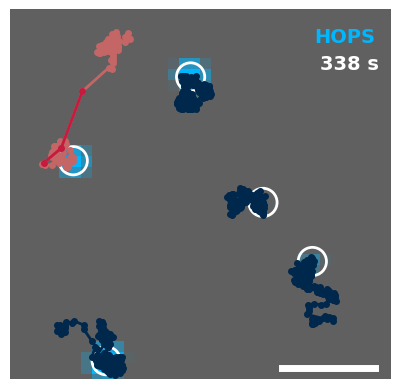

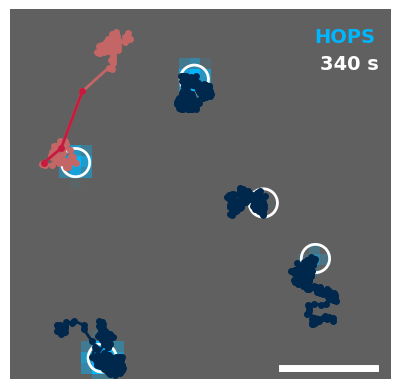

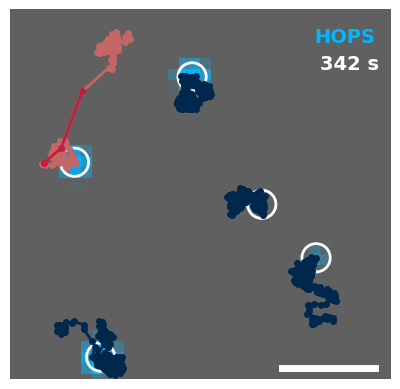

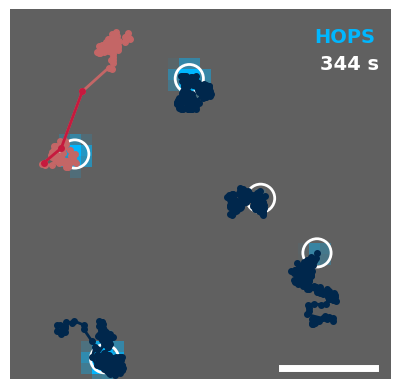

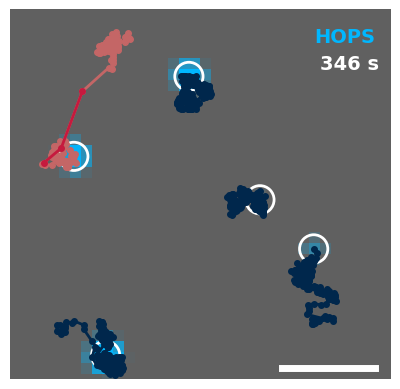

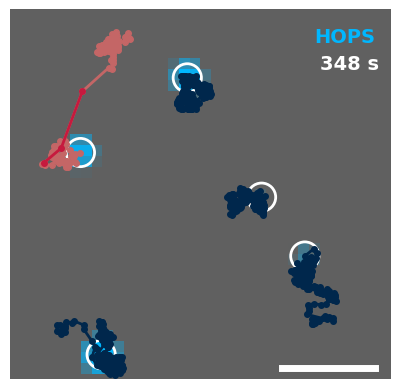

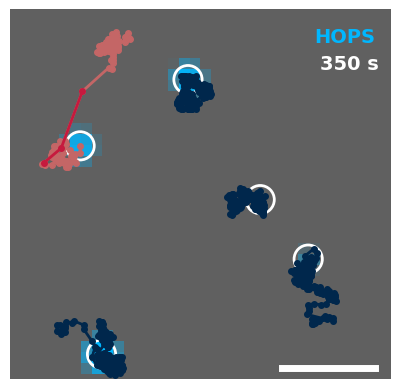

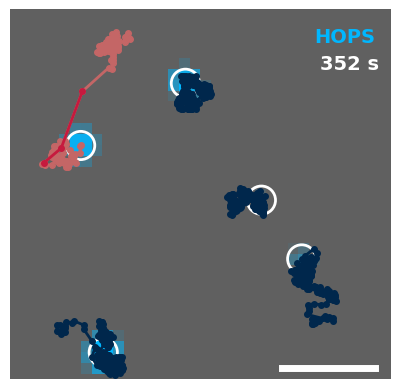

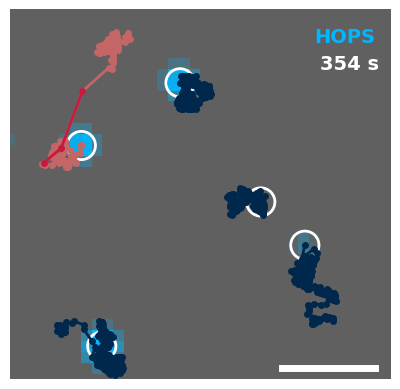

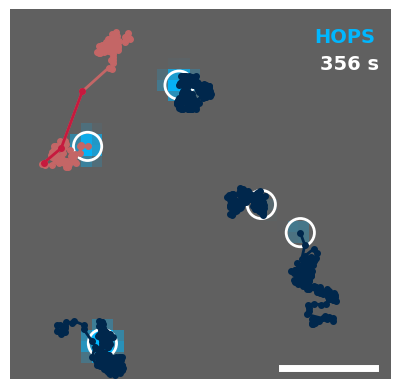

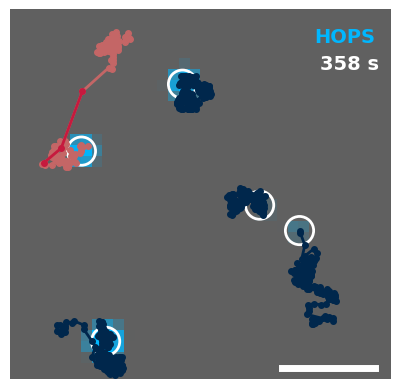

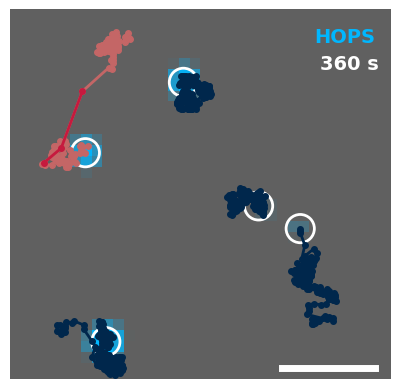

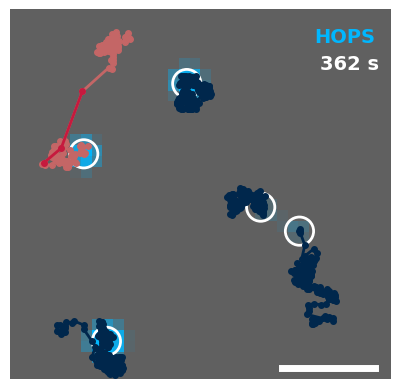

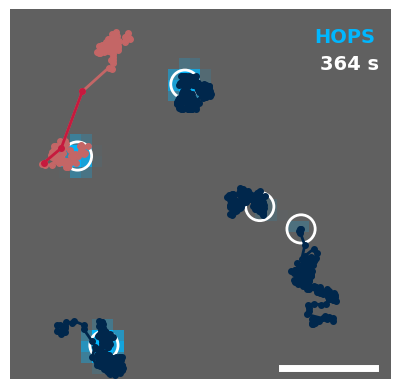

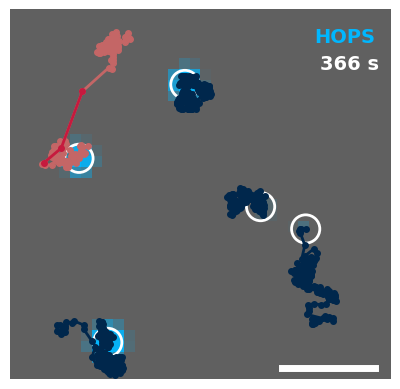

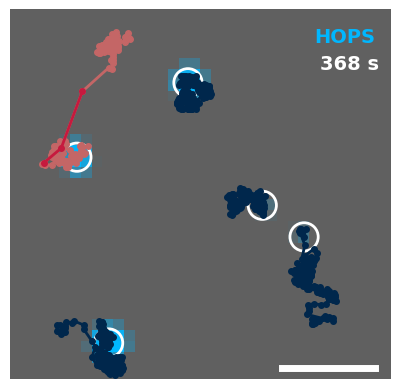

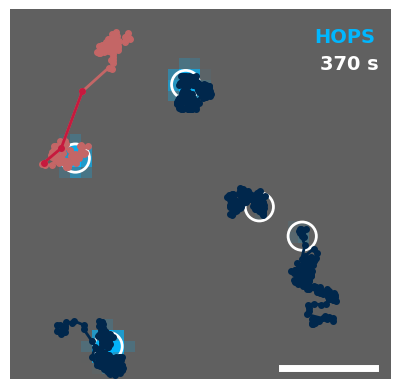

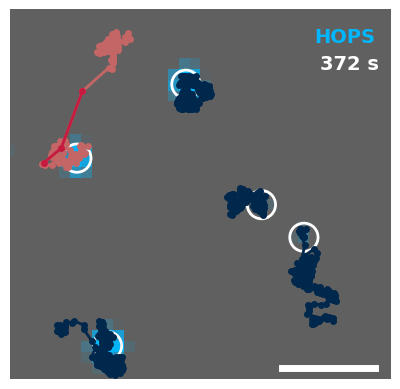

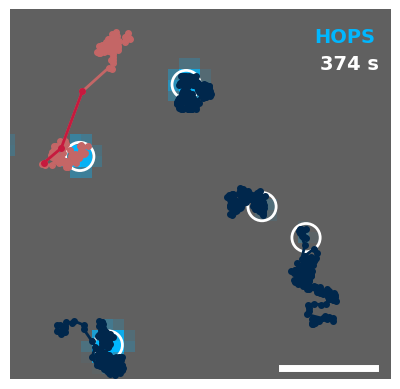

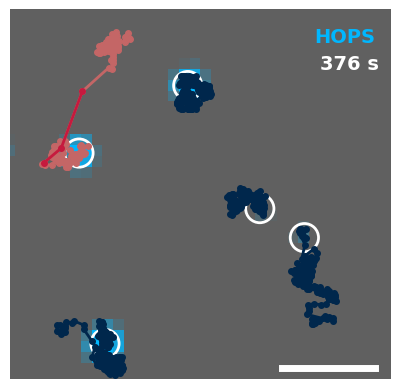

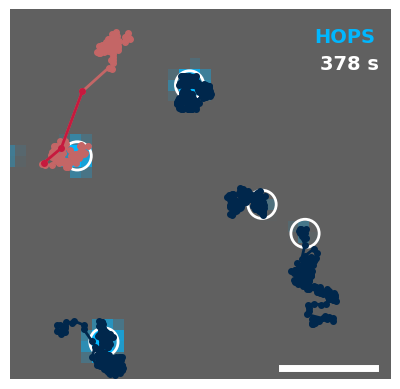

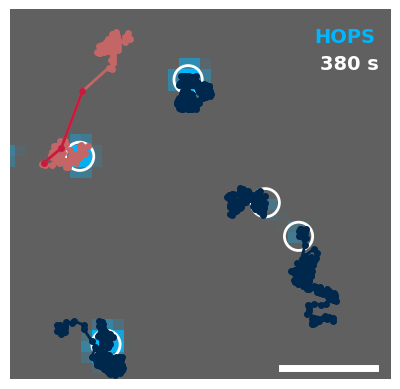

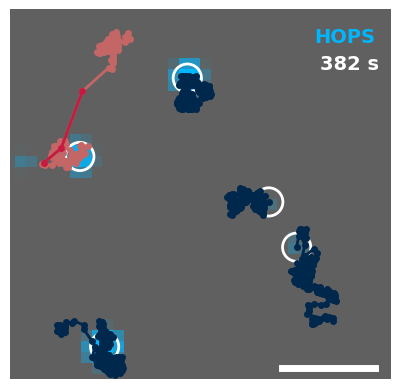

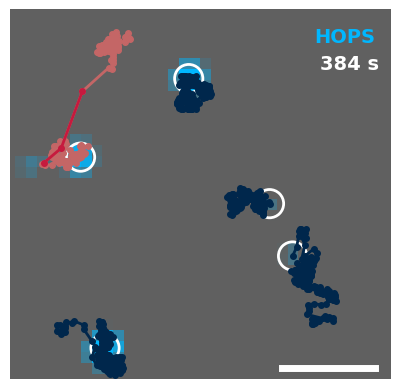

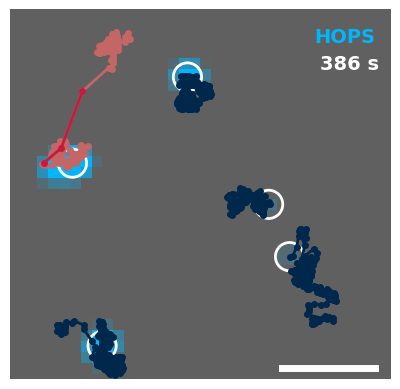

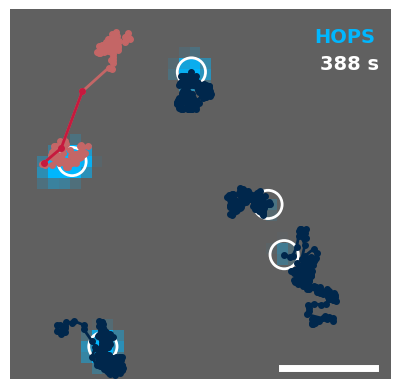

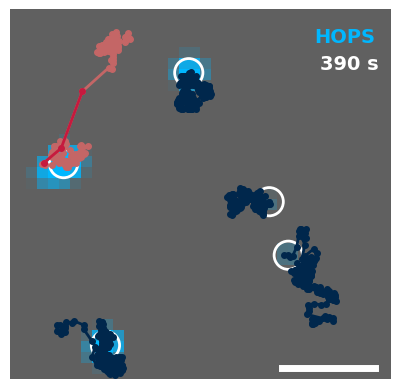

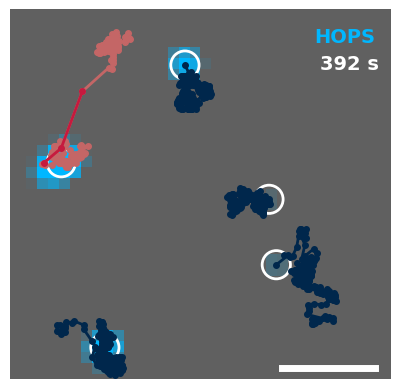

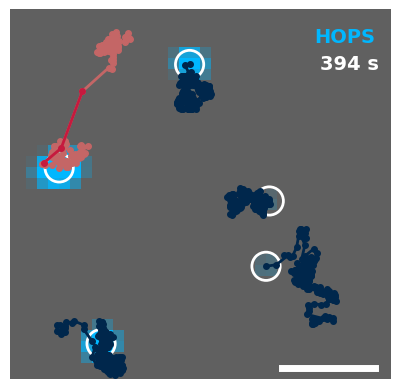

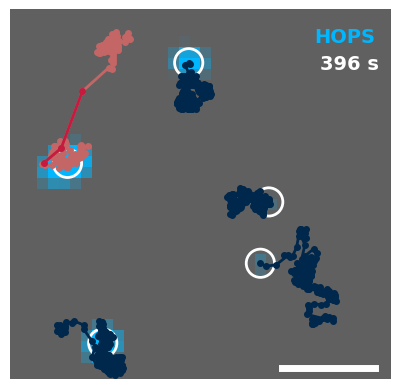

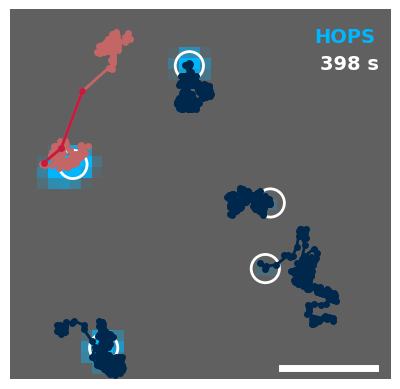

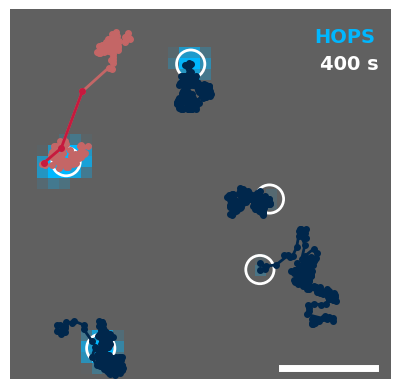

In [ ]:
# Configuration parameters
um_per_pixel = 0.117
s_per_frame = 2
folder_data = r"Z:\\Bisal_Halder_turbo\\PROCESSED_DATA\\Impact_of_cytoskeleton_on_HOPS_condensates\\no_drug\\Analysed Data\\2x\\Trackmate analysis new 07052024\\12062024_for_rep_montage"
folder_save = folder_data

tif_filename = "20240118_UGD-2x-2s-replicate1-FOV-2-bandpass.tif"
csv_filename = "20240118_UGD-2x-2s-replicate1-FOV-2-crop2-wstepflags.csv"

# Load the data
os.chdir(folder_data)
video = imread(tif_filename)
df = pd.read_csv(csv_filename)
df = df.sort_values("t")

# Define parameters
x_min, x_max = 295, 330
y_min, y_max = 490, 524
track_color_other = "#00274c"  # Blue for other trajectories
track_color_195 = "#c46666"  # Color for trackID 195 
track_color_195_flagged = "#c61a3e"  # Color for trackID 195 flagged
condensate_color = "#00B7FF"
background = "#606060"
cmap_condensate = clr.LinearSegmentedColormap.from_list("condensateCmap", [background, condensate_color])

scalebar_length_um = 1
scalebar_length_pxl = scalebar_length_um / um_per_pixel

all_available_frames = set(df["t"].unique())

def find_consecutive_true_ranges(bool_array):
    ranges = []
    n = len(bool_array)
    i = 0

    while i < n:
        if bool_array[i]:
            start = i
            while i < n and bool_array[i]:
                i += 1
            end = i - 1
            ranges.append((start, end))
        i += 1

    return ranges

def animate(frame):
    fig, ax = plt.subplots(1, 1, facecolor = "white", edgecolor = "white")
    
    # Display the image
    img_red = video[frame - 1, :, :]
    ax.imshow(img_red, cmap=cmap_condensate, vmin=2200, vmax=4500)

    # Add time stamp
    ax.text(
        x_min + 28.5,
        y_min + 5.5,
        f"{round(frame * s_per_frame, 2)} s",
        color="white",
        weight="bold",
        size=14,
    )

    # Add HOPS label
    ax.text(
        x_min + 28, 
        y_min + 3, 
        "HOPS", 
        color=condensate_color, 
        weight="bold", 
        size=14,
    )

    # Add tracks
    for track_id in df['trackID'].unique():
        track = df[(df["t"] <= frame - 1) & (df['trackID'] == track_id)]
        
        if track_id == 195:
            flags = track["step_flag"].to_numpy()
            x_plot = track["x"].astype(float)
            y_plot = track["y"].astype(float)
            
            # Plot unflagged segments in track_color_195
            if len(x_plot) > 0:
                ax.plot(
                    x_plot,
                    y_plot,
                    "-o",
                    color=track_color_195,
                    lw=2,
                    markersize=4
                )
            
            # Plot flagged segments in track_color_195_flagged
            true_ranges = find_consecutive_true_ranges(flags)
            for start, end in true_ranges:
                if end < len(x_plot):  
                    ax.plot(
                        x_plot[start: end + 1],
                        y_plot[start: end + 1],
                        "-o",
                        color=track_color_195_flagged,
                        lw=2,
                        markersize=4,
                        markeredgecolor=track_color_195_flagged
                    )
        else:
            x_plot = track["x"].astype(float)
            y_plot = track["y"].astype(float)
            ax.plot(
                x_plot,
                y_plot,
                "-o",
                color=track_color_other,
                lw=2,
                markersize=4
            )

    # Highlight current position        
    if frame - 1 in all_available_frames:
        current_df = df[df["t"] == frame - 1]
        for _, row in current_df.iterrows():
            c = Circle(
                (row["x"], row["y"]), 
                1.3, 
                color="white", 
                fill=False, 
                lw=2
            )
            ax.add_patch(c)

    # Add scale bar
    base_x = x_min + 25
    base_y = y_max - 1
    ax.plot(
        [base_x, base_x + scalebar_length_pxl],
        [base_y, base_y],
        "-",
        color="white",
        lw=5,
    )

    # Set viewing area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.invert_yaxis()
    ax.axis("off")

    # Save the figure
    plt.savefig(join(folder_save, f"frame_{frame:03d}.png"), dpi=600)
    plt.show()
    plt.close(fig)

# Create montage images
num_frames = 200
for frame in range(1, num_frames + 1):
    animate(frame)

# Optional: Create video
ani = FuncAnimation(plt.figure(), animate, frames=200, interval=20, repeat=False)
writer = FuncAnimation.FFMpegWriter(fps=20)
ani.save(join(folder_save, "VideoS_HOPS_Confinement_Jump.mp4"), writer=writer, dpi=600)